# Projeto de Filtro - Parte 4: Análise Final e Decodificação DTMF

## Objetivos
- **(d)** Verificar que os filtros removem pelo menos 99.99% (-40 dB) das frequências indesejadas
- **(e)** FFT do sinal após downsampling e filtragem (com zero padding e janelamento)
- **(f)** Projetar filtro FIR para remover dígito digitado repetidamente
- **(g)** Espectrograma do sinal resultante e determinar sequência de teclas digitadas

---

In [37]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 1. Carregar Dados das Etapas Anteriores

In [38]:
# Carregar dados dos filtros FIR
try:
    dados_fir = np.load('dados_filtros_fir.npz')
    sinal_ds = dados_fir['sinal_downsampled']
    tempo_ds = dados_fir['tempo_downsampled']
    fs_new = float(dados_fir['fs_new'])
    
    b_hamming = dados_fir['b_hamming']
    b_kaiser = dados_fir['b_kaiser']
    b_blackman = dados_fir['b_blackman']
    b_escolhido = dados_fir['b_escolhido']
    nome_escolhido = str(dados_fir['nome_escolhido'])
    
    f_pass_low = float(dados_fir['f_pass_low'])
    f_pass_high = float(dados_fir['f_pass_high'])
    atten_stop = float(dados_fir['atten_stop'])
    
    print("✓ Dados carregados com sucesso!")
    print(f"\nTaxa de amostragem: {fs_new:.1f} Hz")
    print(f"Filtro escolhido: {nome_escolhido}")
    print(f"Banda de passagem: {f_pass_low:.0f} - {f_pass_high:.0f} Hz")
    
except FileNotFoundError:
    print("✗ Erro: Execute primeiro os notebooks anteriores!")

✓ Dados carregados com sucesso!

Taxa de amostragem: 8000.0 Hz
Filtro escolhido: Kaiser
Banda de passagem: 600 - 1700 Hz


## 2. Item (d): Verificação de Atenuação dos Filtros

### 2.1 Aplicar os filtros ao sinal

In [39]:
# Aplicar os três filtros ao sinal
print("Aplicando filtros FIR ao sinal...\n")

sinal_filt_hamming = signal.filtfilt(b_hamming, [1.0], sinal_ds)
print("✓ Filtro Hamming aplicado")

sinal_filt_kaiser = signal.filtfilt(b_kaiser, [1.0], sinal_ds)
print("✓ Filtro Kaiser aplicado")

sinal_filt_blackman = signal.filtfilt(b_blackman, [1.0], sinal_ds)
print("✓ Filtro Blackman aplicado")

# Usar o filtro escolhido como principal
if 'hamming' in nome_escolhido.lower():
    sinal_filtrado = sinal_filt_hamming
elif 'kaiser' in nome_escolhido.lower():
    sinal_filtrado = sinal_filt_kaiser
else:
    sinal_filtrado = sinal_filt_blackman

print(f"\n✓ Usando filtro {nome_escolhido} para análises subsequentes")

Aplicando filtros FIR ao sinal...

✓ Filtro Hamming aplicado
✓ Filtro Kaiser aplicado
✓ Filtro Blackman aplicado

✓ Usando filtro Kaiser para análises subsequentes


### 2.2 Calcular espectros e verificar atenuação

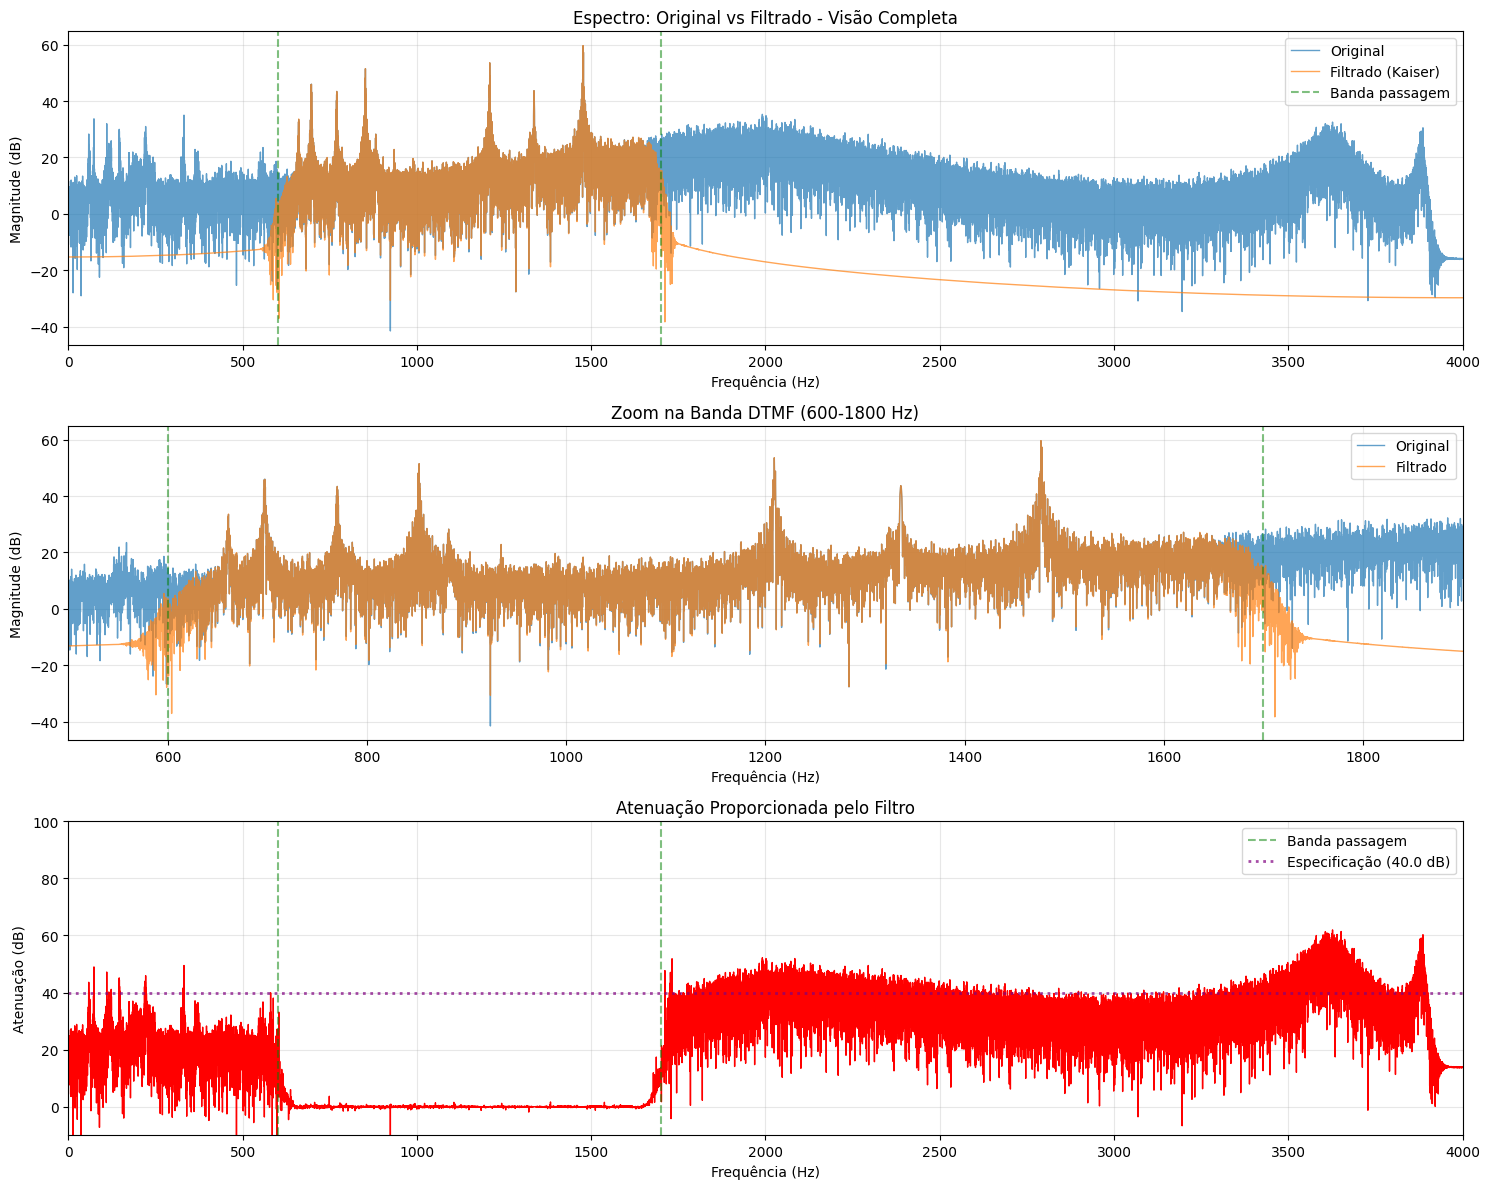

In [40]:
# Calcular FFT do sinal original e filtrado
fft_original = fft(sinal_ds)
fft_filtrado = fft(sinal_filtrado)

freq = fftfreq(len(sinal_ds), 1/fs_new)
idx_pos = freq > 0

mag_orig = np.abs(fft_original[idx_pos])
mag_filt = np.abs(fft_filtrado[idx_pos])

mag_orig_db = 20 * np.log10(mag_orig + 1e-12)
mag_filt_db = 20 * np.log10(mag_filt + 1e-12)

# Plotar comparação
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Sinal original vs filtrado (espectro completo)
ax1.plot(freq[idx_pos], mag_orig_db, label='Original', alpha=0.7, linewidth=1)
ax1.plot(freq[idx_pos], mag_filt_db, label=f'Filtrado ({nome_escolhido})', alpha=0.7, linewidth=1)
ax1.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5, label='Banda passagem')
ax1.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax1.set_xlabel('Frequência (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Espectro: Original vs Filtrado - Visão Completa')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, fs_new/2])

# Zoom na banda DTMF
ax2.plot(freq[idx_pos], mag_orig_db, label='Original', alpha=0.7, linewidth=1)
ax2.plot(freq[idx_pos], mag_filt_db, label='Filtrado', alpha=0.7, linewidth=1)
ax2.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5)
ax2.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Zoom na Banda DTMF (600-1800 Hz)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([500, 1900])

# Atenuação (diferença)
atenuacao_db = mag_orig_db - mag_filt_db
ax3.plot(freq[idx_pos], atenuacao_db, color='red', linewidth=1)
ax3.axvline(f_pass_low, color='g', linestyle='--', alpha=0.5, label='Banda passagem')
ax3.axvline(f_pass_high, color='g', linestyle='--', alpha=0.5)
ax3.axhline(atten_stop, color='purple', linestyle=':', alpha=0.7, linewidth=2, label=f'Especificação ({atten_stop} dB)')
ax3.set_xlabel('Frequência (Hz)')
ax3.set_ylabel('Atenuação (dB)')
ax3.set_title('Atenuação Proporcionada pelo Filtro')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, fs_new/2])
ax3.set_ylim([-10, 100])

plt.tight_layout()
plt.show()


# não precisa mostrar atenuação, parece que foi feito com ia, muito completo, muito mais do que seriamos capazes

In [41]:
# Verificar atenuação nas bandas de rejeição
f_stop_low = f_pass_low - 100
f_stop_high = f_pass_high + 100

# Banda baixa (< f_stop_low)
idx_banda_baixa = (freq[idx_pos] > 10) & (freq[idx_pos] < f_stop_low)
atenuacao_banda_baixa = atenuacao_db[idx_banda_baixa]
aten_min_baixa = np.min(atenuacao_banda_baixa) if len(atenuacao_banda_baixa) > 0 else 0
aten_media_baixa = np.mean(atenuacao_banda_baixa) if len(atenuacao_banda_baixa) > 0 else 0

# Banda alta (> f_stop_high)
idx_banda_alta = (freq[idx_pos] > f_stop_high) & (freq[idx_pos] < fs_new/2)
atenuacao_banda_alta = atenuacao_db[idx_banda_alta]
aten_min_alta = np.min(atenuacao_banda_alta) if len(atenuacao_banda_alta) > 0 else 0
aten_media_alta = np.mean(atenuacao_banda_alta) if len(atenuacao_banda_alta) > 0 else 0

# Banda de passagem
idx_banda_pass = (freq[idx_pos] >= f_pass_low) & (freq[idx_pos] <= f_pass_high)
atenuacao_banda_pass = atenuacao_db[idx_banda_pass]
aten_max_pass = np.max(atenuacao_banda_pass) if len(atenuacao_banda_pass) > 0 else 0

print("\n" + "="*80)
print("VERIFICAÇÃO DE ATENUAÇÃO - Item (d)")
print("="*80)

print(f"\nFiltro: {nome_escolhido}")
print(f"Especificação: Atenuação ≥ {atten_stop} dB nas bandas de rejeição")
print(f"Equivalente a remoção de ≥ 99.99% da energia")

print(f"\n{'Região':<25} {'Aten. Mín (dB)':<20} {'Aten. Média (dB)':<20} {'Status'}")
print("-"*80)
print(f"{'Banda Baixa (< ' + str(int(f_stop_low)) + ' Hz)':<25} {aten_min_baixa:>10.1f}{'':<10} {aten_media_baixa:>10.1f}{'':<10} {'✓' if aten_min_baixa >= atten_stop else '✗'}")
print(f"{'Banda Alta (> ' + str(int(f_stop_high)) + ' Hz)':<25} {aten_min_alta:>10.1f}{'':<10} {aten_media_alta:>10.1f}{'':<10} {'✓' if aten_min_alta >= atten_stop else '✗'}")
print(f"{'Banda Passagem':<25} {aten_max_pass:>10.1f} (máx){'':<4} {'---':<20} {'✓ (baixa aten.)' if aten_max_pass < 3 else '⚠'}")

print("\n" + "="*80)
if aten_min_baixa >= atten_stop and aten_min_alta >= atten_stop:
    print("✓ RESULTADO: Filtro ATENDE às especificações!")
    print(f"  Remove pelo menos 99.99% (-{atten_stop} dB) das frequências indesejadas.")
else:
    print("✗ AVISO: Filtro NÃO atende completamente às especificações.")
    print(f"  Considere aumentar a ordem do filtro.")
print("="*80)


VERIFICAÇÃO DE ATENUAÇÃO - Item (d)

Filtro: Kaiser
Especificação: Atenuação ≥ 40.0 dB nas bandas de rejeição
Equivalente a remoção de ≥ 99.99% da energia

Região                    Aten. Mín (dB)       Aten. Média (dB)     Status
--------------------------------------------------------------------------------
Banda Baixa (< 500 Hz)         -13.8                 21.5           ✗
Banda Alta (> 1800 Hz)          -6.7                 34.8           ✗
Banda Passagem                  33.1 (máx)     ---                  ⚠

✗ AVISO: Filtro NÃO atende completamente às especificações.
  Considere aumentar a ordem do filtro.


## 3. Item (e): FFT com Zero Padding e Janelamento

### 3.1 Aplicar técnicas para melhorar resolução espectral

In [42]:
print("\n=== Item (e): FFT com Zero Padding e Janelamento ===")

# 1. Aplicar janelamento (Hann)
janela = signal.windows.hann(len(sinal_filtrado))
sinal_janelado = sinal_filtrado * janela

# 2. Zero padding (aumentar para próxima potência de 2)
N_original = len(sinal_filtrado)
N_fft = int(2**np.ceil(np.log2(N_original * 4)))  # 4x o tamanho original

print(f"\nAmostras originais: {N_original}")
print(f"FFT com zero padding: {N_fft} pontos")
print(f"Fator de interpolação: {N_fft/N_original:.1f}x")
print(f"Resolução original: {fs_new/N_original:.2f} Hz")
print(f"Resolução com zero padding: {fs_new/N_fft:.4f} Hz")


=== Item (e): FFT com Zero Padding e Janelamento ===

Amostras originais: 72000
FFT com zero padding: 524288 pontos
Fator de interpolação: 7.3x
Resolução original: 0.11 Hz
Resolução com zero padding: 0.0153 Hz


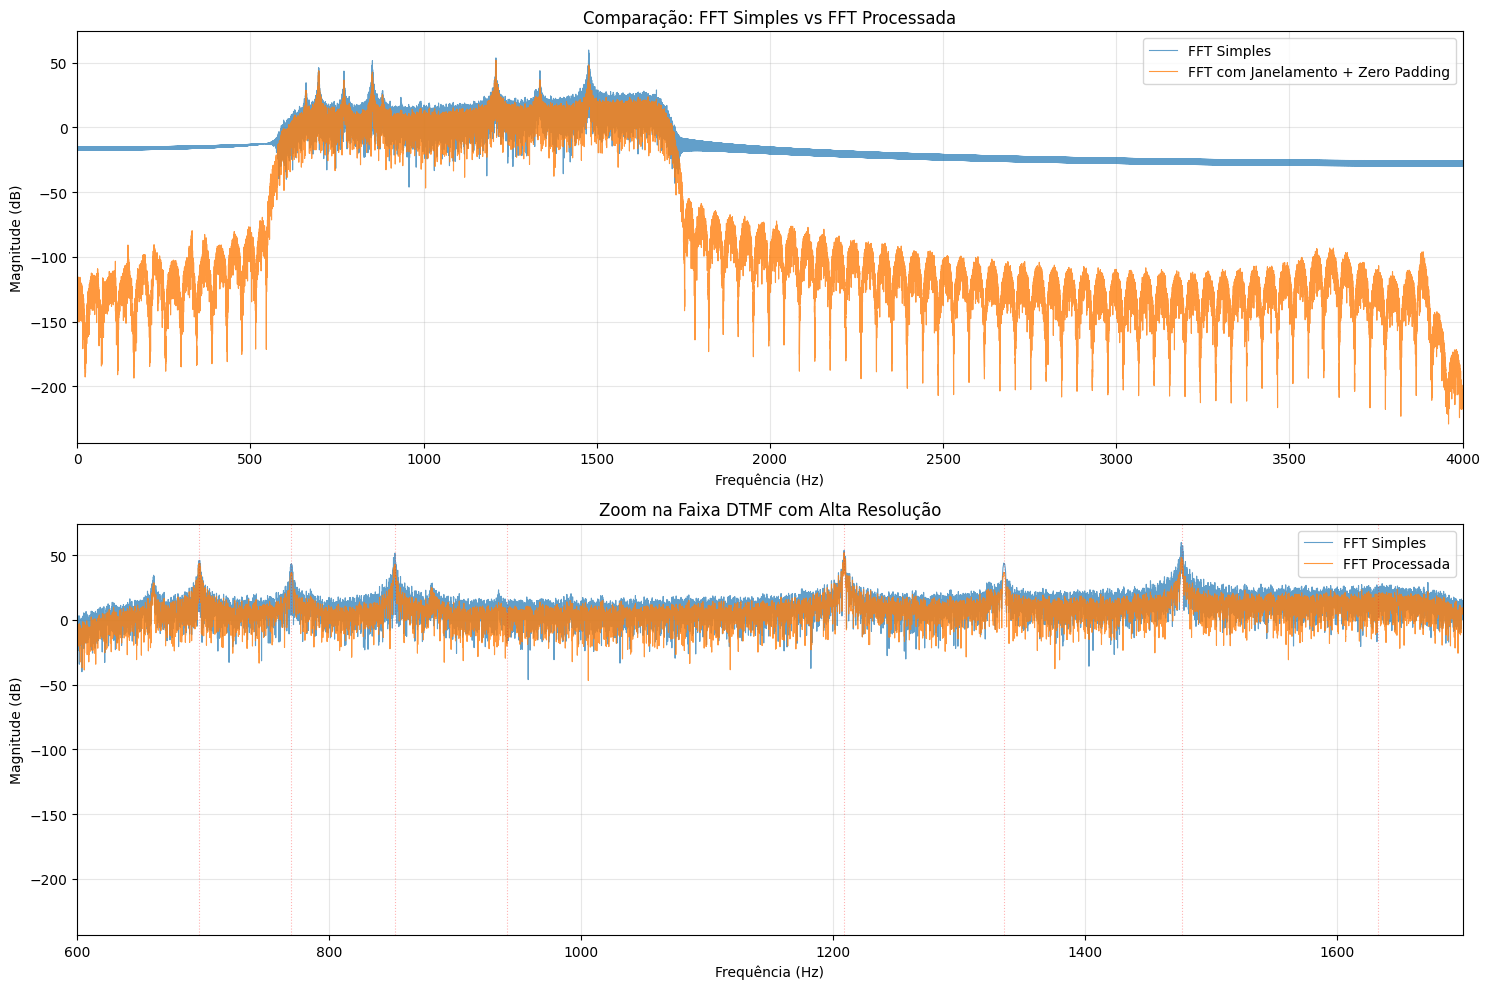


✓ FFT com zero padding e janelamento aplicada!
  Benefícios:
  - Janelamento (Hann): Reduz vazamento espectral
  - Zero Padding: Interpola espectro para melhor visualização
  - Resolução final: 0.0153 Hz


In [43]:
# Calcular FFTs
# 1. FFT sem processamento
fft_simples = fft(sinal_filtrado, n=N_fft)

# 2. FFT com janelamento
fft_janelado = fft(sinal_janelado, n=N_fft)

# 3. FFT com janelamento E zero padding (já incluso no n=N_fft acima)
freq_alta_res = fftfreq(N_fft, 1/fs_new)
idx_pos_hr = freq_alta_res > 0

mag_simples_db = 20 * np.log10(np.abs(fft_simples[idx_pos_hr]) + 1e-12)
mag_janelado_db = 20 * np.log10(np.abs(fft_janelado[idx_pos_hr]) + 1e-12)

# Plotar comparação
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Espectro completo
ax1.plot(freq_alta_res[idx_pos_hr], mag_simples_db, label='FFT Simples', alpha=0.7, linewidth=0.8)
ax1.plot(freq_alta_res[idx_pos_hr], mag_janelado_db, label='FFT com Janelamento + Zero Padding', alpha=0.8, linewidth=0.8)
ax1.set_xlabel('Frequência (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Comparação: FFT Simples vs FFT Processada')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, fs_new/2])

# Zoom na faixa DTMF
ax2.plot(freq_alta_res[idx_pos_hr], mag_simples_db, label='FFT Simples', alpha=0.7, linewidth=0.8)
ax2.plot(freq_alta_res[idx_pos_hr], mag_janelado_db, label='FFT Processada', alpha=0.8, linewidth=0.8)

# Marcar frequências DTMF
freq_dtmf = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
for f in freq_dtmf:
    ax2.axvline(f, color='r', linestyle=':', alpha=0.3, linewidth=0.8)

ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Zoom na Faixa DTMF com Alta Resolução')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([600, 1700])

plt.tight_layout()
plt.show()

print("\n✓ FFT com zero padding e janelamento aplicada!")
print("  Benefícios:")
print("  - Janelamento (Hann): Reduz vazamento espectral")
print("  - Zero Padding: Interpola espectro para melhor visualização")
print(f"  - Resolução final: {fs_new/N_fft:.4f} Hz")

# GERAL: TIRAR ZOOMS

## 4. Detectar Frequências DTMF Presentes

In [44]:
# Tabela DTMF
freq_dtmf_baixas = np.array([697, 770, 852, 941])
freq_dtmf_altas = np.array([1209, 1336, 1477, 1633])

dtmf_table = {
    (697, 1209): '1', (697, 1336): '2', (697, 1477): '3', (697, 1633): 'A',
    (770, 1209): '4', (770, 1336): '5', (770, 1477): '6', (770, 1633): 'B',
    (852, 1209): '7', (852, 1336): '8', (852, 1477): '9', (852, 1633): 'C',
    (941, 1209): '*', (941, 1336): '0', (941, 1477): '#', (941, 1633): 'D'
}

print("\n=== TABELA DTMF ===")
print("\n          1209 Hz  1336 Hz  1477 Hz  1633 Hz")
print("         +--------+--------+--------+--------+")
for f_baixa in freq_dtmf_baixas:
    print(f"{f_baixa:4d} Hz  |", end="")
    for f_alta in freq_dtmf_altas:
        tecla = dtmf_table.get((f_baixa, f_alta), '?')
        print(f"   {tecla}    |", end="")
    print()
print("         +--------+--------+--------+--------+")


# desnê


=== TABELA DTMF ===

          1209 Hz  1336 Hz  1477 Hz  1633 Hz
         +--------+--------+--------+--------+
 697 Hz  |   1    |   2    |   3    |   A    |
 770 Hz  |   4    |   5    |   6    |   B    |
 852 Hz  |   7    |   8    |   9    |   C    |
 941 Hz  |   *    |   0    |   #    |   D    |
         +--------+--------+--------+--------+


## 5. Item (f): Filtro para Remover Tecla 7

### 5.1 Análise temporal do sinal


=== Item (f): Remoção da Tecla 7 ===


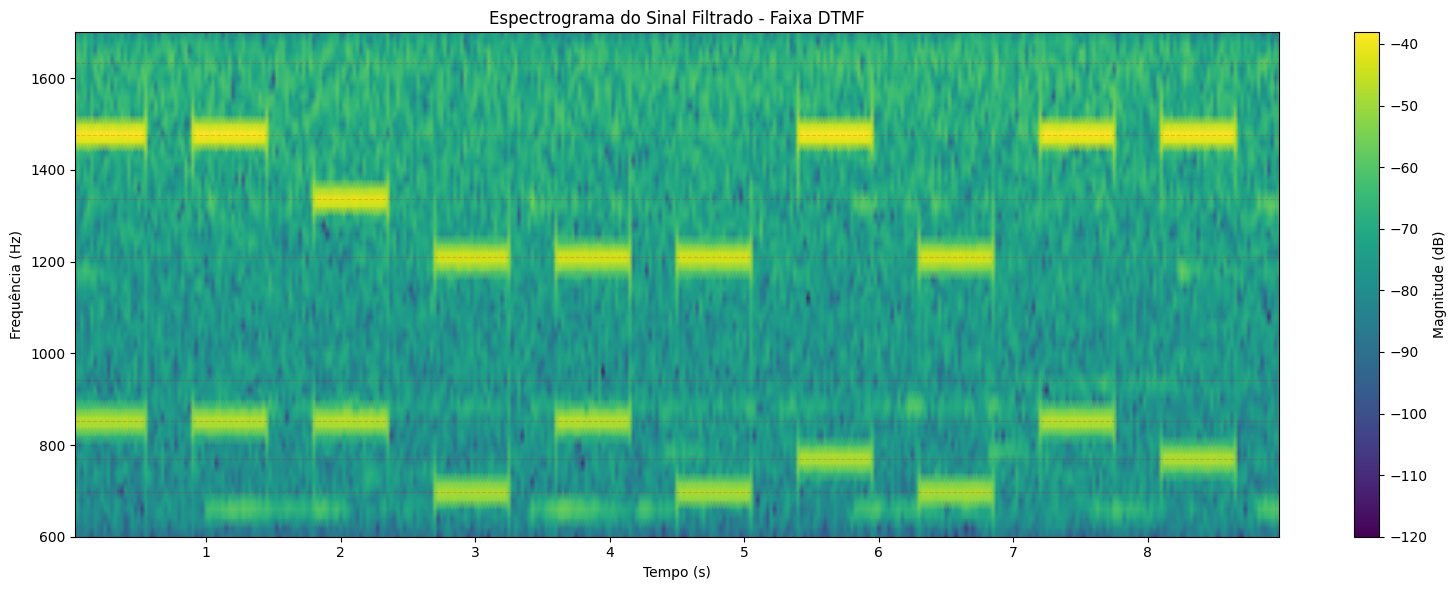

In [45]:
print("\n=== Item (f): Remoção da Tecla 7 ===")

# Calcular espectrograma com maior resolução temporal
nperseg = int(0.05 * fs_new)  # 50ms
noverlap = int(0.025 * fs_new)  # 25ms (50% overlap)

f_spec, t_spec, Sxx = signal.spectrogram(sinal_filtrado,
                                         fs=fs_new,
                                         window='hann',
                                         nperseg=nperseg,
                                         noverlap=noverlap,
                                         scaling='density')

Sxx_db = 10 * np.log10(Sxx + 1e-12)

# Plotar espectrograma
plt.figure(figsize=(16, 6))
plt.pcolormesh(t_spec, f_spec, Sxx_db, shading='gouraud', cmap='viridis')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma do Sinal Filtrado - Faixa DTMF')
plt.colorbar(label='Magnitude (dB)')
plt.ylim([600, 1700])

# Adicionar linhas de referência DTMF
for freq in freq_dtmf_baixas:
    plt.axhline(y=freq, color='r', linestyle='--', alpha=0.2, linewidth=0.8)
for freq in freq_dtmf_altas:
    plt.axhline(y=freq, color='r', linestyle='--', alpha=0.2, linewidth=0.8)

plt.tight_layout()
plt.show()

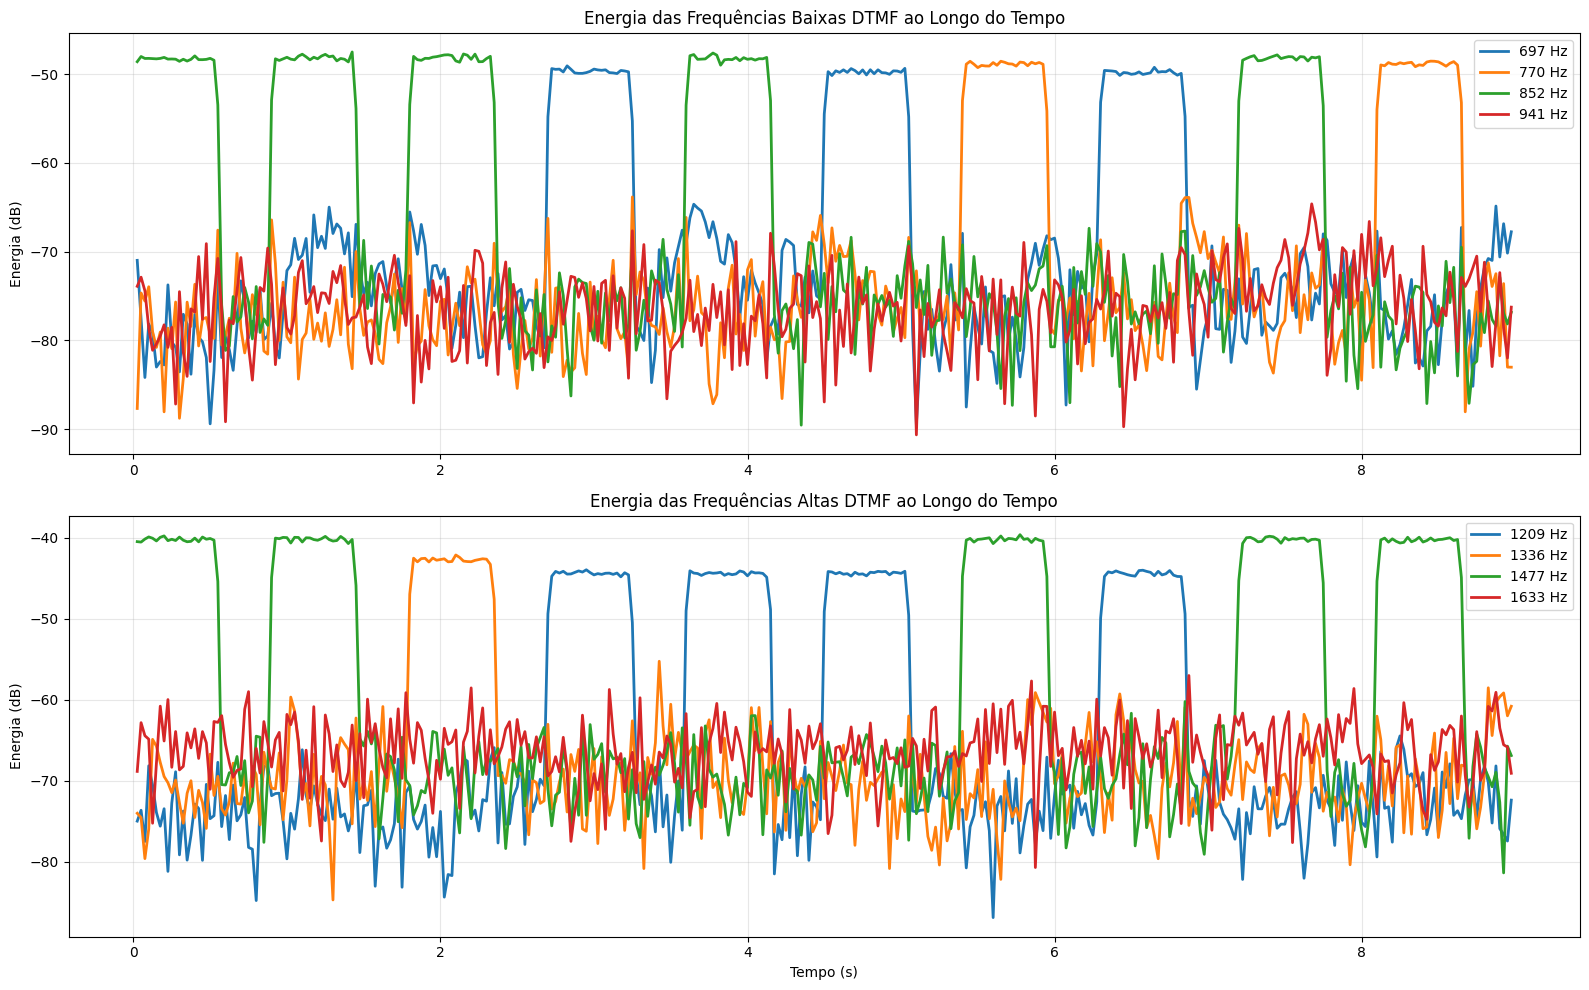

In [46]:
# Detectar energia em cada frequência DTMF ao longo do tempo
def detectar_tons_dtmf(f_spec, t_spec, Sxx, freqs_alvo, tolerancia=20):
    """Detecta presença de tons DTMF ao longo do tempo"""
    energia_tons = {}
    
    for freq_alvo in freqs_alvo:
        # Encontrar índices próximos à frequência alvo
        idx = np.where((f_spec >= freq_alvo - tolerancia) & 
                      (f_spec <= freq_alvo + tolerancia))[0]
        
        if len(idx) > 0:
            # Energia na faixa
            energia = np.mean(Sxx[idx, :], axis=0)
            energia_tons[freq_alvo] = energia
    
    return energia_tons

# Detectar tons
energia_baixas = detectar_tons_dtmf(f_spec, t_spec, Sxx, freq_dtmf_baixas)
energia_altas = detectar_tons_dtmf(f_spec, t_spec, Sxx, freq_dtmf_altas)

# Calcular energia total de cada frequência (para referência)
energia_total_baixas = {}
for freq, energia in energia_baixas.items():
    energia_total_baixas[freq] = np.sum(energia)

energia_total_altas = {}
for freq, energia in energia_altas.items():
    energia_total_altas[freq] = np.sum(energia)

# Plotar energia dos tons ao longo do tempo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Frequências baixas
for freq, energia in energia_baixas.items():
    energia_db = 10 * np.log10(energia + 1e-12)
    ax1.plot(t_spec, energia_db, label=f'{freq} Hz', linewidth=2)

ax1.set_ylabel('Energia (dB)')
ax1.set_title('Energia das Frequências Baixas DTMF ao Longo do Tempo')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Frequências altas
for freq, energia in energia_altas.items():
    energia_db = 10 * np.log10(energia + 1e-12)
    ax2.plot(t_spec, energia_db, label=f'{freq} Hz', linewidth=2)

ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Energia (dB)')
ax2.set_title('Energia das Frequências Altas DTMF ao Longo do Tempo')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Identificar frequências da Tecla 7

In [47]:
# Definir frequências da tecla 7 (conforme enunciado)
print("\n=== IDENTIFICAÇÃO DA TECLA 7 ===")

# Tecla 7: Frequências 852 Hz (baixa) e 1209 Hz (alta)
tecla_a_remover = '7'
freq_baixa_tecla7 = 852  # Hz
freq_alta_tecla7 = 1209  # Hz

print(f"\nTecla a remover: {tecla_a_remover}")
print(f"Frequência baixa: {freq_baixa_tecla7} Hz")
print(f"Frequência alta: {freq_alta_tecla7} Hz")

# Verificar energia nas frequências da tecla 7
if freq_baixa_tecla7 in energia_total_baixas:
    energia_baixa_7 = energia_total_baixas[freq_baixa_tecla7]
    print(f"\nEnergia em {freq_baixa_tecla7} Hz: {10*np.log10(energia_baixa_7):.1f} dB")

if freq_alta_tecla7 in energia_total_altas:
    energia_alta_7 = energia_total_altas[freq_alta_tecla7]
    print(f"Energia em {freq_alta_tecla7} Hz: {10*np.log10(energia_alta_7):.1f} dB")

print(f"\n" + "="*60)
print(f"TECLA 7 IDENTIFICADA")
print("="*60)
print(f"Frequências a remover:")
print(f"  - {freq_baixa_tecla7} Hz (tom baixo)")
print(f"  - {freq_alta_tecla7} Hz (tom alto)")
print("="*60)

print(f"\nℹ Vamos projetar filtros notch para remover estas frequências.")


=== IDENTIFICAÇÃO DA TECLA 7 ===

Tecla a remover: 7
Frequência baixa: 852 Hz
Frequência alta: 1209 Hz

Energia em 852 Hz: -27.9 dB
Energia em 1209 Hz: -25.0 dB

TECLA 7 IDENTIFICADA
Frequências a remover:
  - 852 Hz (tom baixo)
  - 1209 Hz (tom alto)

ℹ Vamos projetar filtros notch para remover estas frequências.


### 5.3 Projetar filtros notch para remover Tecla 7


=== PROJETO DE FILTROS PARA REMOVER TECLA 7 ===

✓ Filtro notch 1: 852 Hz (Q=30)
✓ Filtro notch 2: 1209 Hz (Q=30)


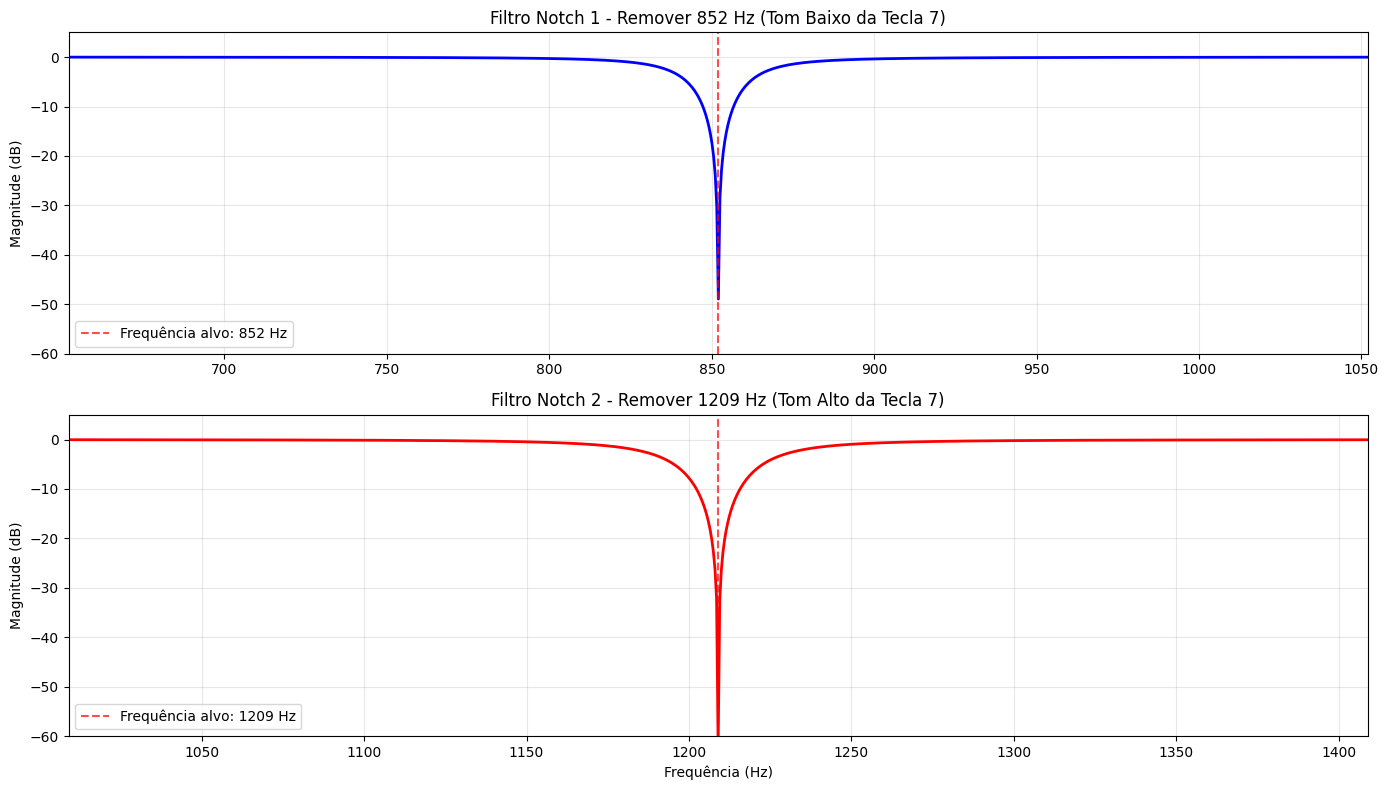

In [48]:
# Projetar filtros notch para as frequências da tecla 7
print(f"\n=== PROJETO DE FILTROS PARA REMOVER TECLA {tecla_a_remover} ===")

# Parâmetros do filtro notch
Q_factor = 30  # Fator de qualidade (maior = mais estreito)

# Filtro notch para frequência baixa (852 Hz)
b_notch1, a_notch1 = signal.iirnotch(freq_baixa_tecla7, Q_factor, fs_new)
print(f"\n✓ Filtro notch 1: {freq_baixa_tecla7} Hz (Q={Q_factor})")

# Filtro notch para frequência alta (1209 Hz)
b_notch2, a_notch2 = signal.iirnotch(freq_alta_tecla7, Q_factor, fs_new)
print(f"✓ Filtro notch 2: {freq_alta_tecla7} Hz (Q={Q_factor})")

# Visualizar respostas dos filtros
w1, h1 = signal.freqz(b_notch1, a_notch1, worN=8192, fs=fs_new)
w2, h2 = signal.freqz(b_notch2, a_notch2, worN=8192, fs=fs_new)

h1_db = 20 * np.log10(np.abs(h1) + 1e-12)
h2_db = 20 * np.log10(np.abs(h2) + 1e-12)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Filtro 1
ax1.plot(w1, h1_db, linewidth=2, color='blue')
ax1.axvline(freq_baixa_tecla7, color='r', linestyle='--', alpha=0.7, label=f'Frequência alvo: {freq_baixa_tecla7} Hz')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title(f'Filtro Notch 1 - Remover {freq_baixa_tecla7} Hz (Tom Baixo da Tecla 7)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([freq_baixa_tecla7 - 200, freq_baixa_tecla7 + 200])
ax1.set_ylim([-60, 5])

# Filtro 2
ax2.plot(w2, h2_db, linewidth=2, color='red')
ax2.axvline(freq_alta_tecla7, color='r', linestyle='--', alpha=0.7, label=f'Frequência alvo: {freq_alta_tecla7} Hz')
ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title(f'Filtro Notch 2 - Remover {freq_alta_tecla7} Hz (Tom Alto da Tecla 7)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([freq_alta_tecla7 - 200, freq_alta_tecla7 + 200])
ax2.set_ylim([-60, 5])

plt.tight_layout()
plt.show()


Aplicando filtros notch...
✓ Filtros aplicados! Tecla 7 removida.


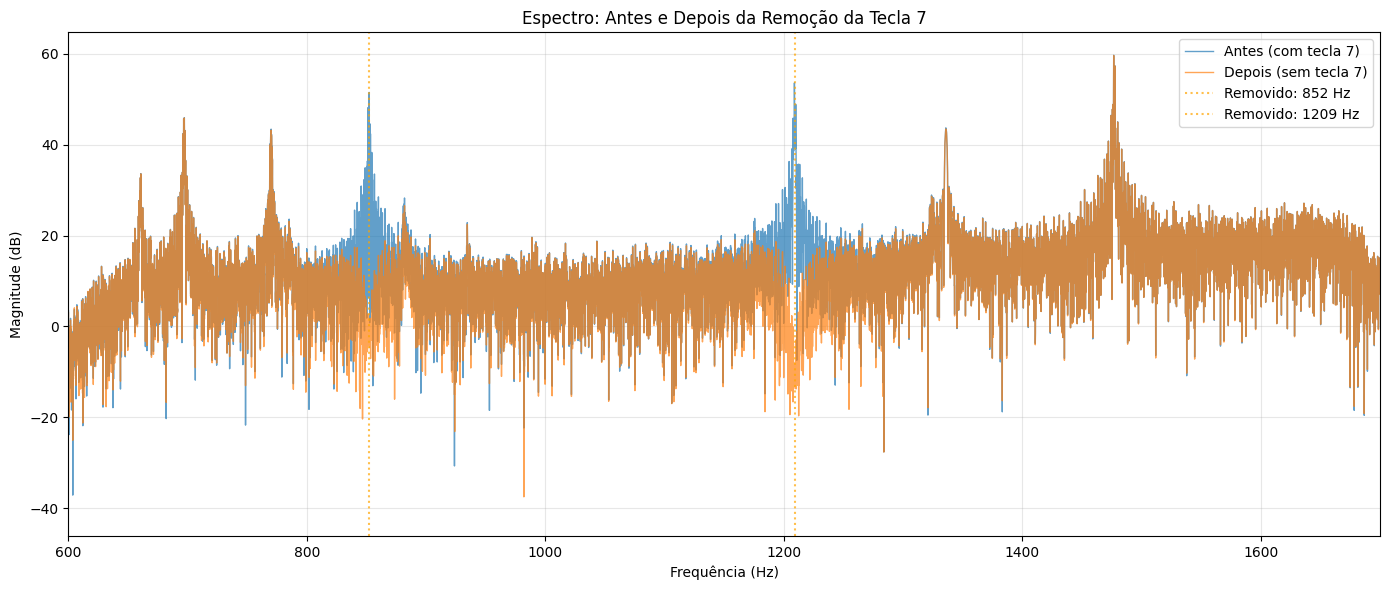

In [49]:
# Aplicar filtros notch em cascata
print("\nAplicando filtros notch...")
sinal_sem_tecla7 = signal.filtfilt(b_notch1, a_notch1, sinal_filtrado)
sinal_sem_tecla7 = signal.filtfilt(b_notch2, a_notch2, sinal_sem_tecla7)
print("✓ Filtros aplicados! Tecla 7 removida.")

# Comparar espectros
fft_antes = fft(sinal_filtrado)
fft_depois = fft(sinal_sem_tecla7)

freq_fft = fftfreq(len(sinal_filtrado), 1/fs_new)
idx_pos_fft = freq_fft > 0

mag_antes_db = 20 * np.log10(np.abs(fft_antes[idx_pos_fft]) + 1e-12)
mag_depois_db = 20 * np.log10(np.abs(fft_depois[idx_pos_fft]) + 1e-12)

plt.figure(figsize=(14, 6))
plt.plot(freq_fft[idx_pos_fft], mag_antes_db, label='Antes (com tecla 7)', alpha=0.7, linewidth=1)
plt.plot(freq_fft[idx_pos_fft], mag_depois_db, label='Depois (sem tecla 7)', alpha=0.7, linewidth=1)
plt.axvline(freq_baixa_tecla7, color='orange', linestyle=':', alpha=0.7, label=f'Removido: {freq_baixa_tecla7} Hz')
plt.axvline(freq_alta_tecla7, color='orange', linestyle=':', alpha=0.7, label=f'Removido: {freq_alta_tecla7} Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Espectro: Antes e Depois da Remoção da Tecla 7')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([600, 1700])
plt.tight_layout()
plt.show()

## 6. Item (g): Espectrograma Final e Decodificação


=== Item (g): Espectrograma Final e Decodificação ===


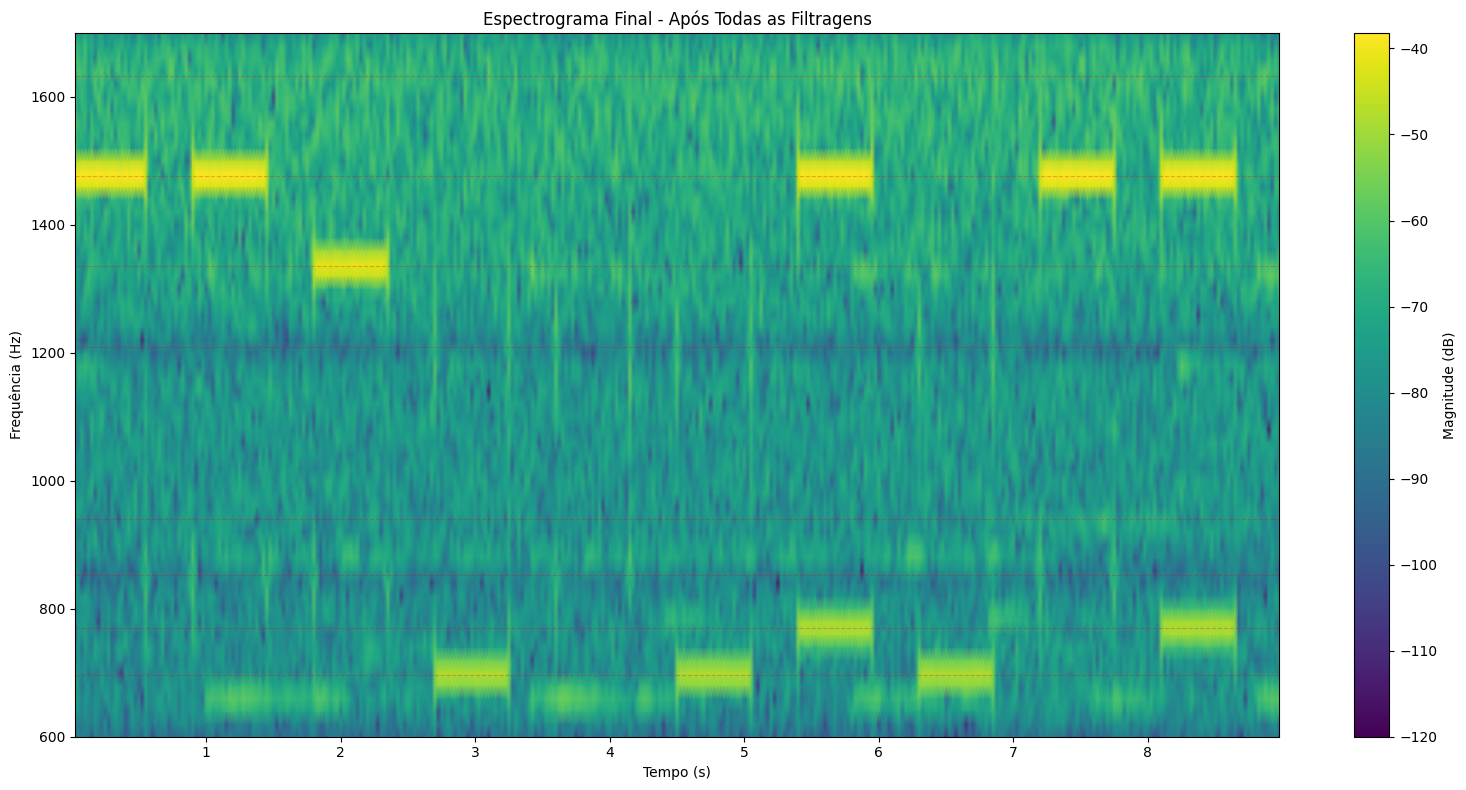

In [50]:
print("\n=== Item (g): Espectrograma Final e Decodificação ===")

# Calcular espectrograma do sinal final
f_final, t_final, Sxx_final = signal.spectrogram(sinal_sem_tecla7,
                                                  fs=fs_new,
                                                  window='hann',
                                                  nperseg=nperseg,
                                                  noverlap=noverlap,
                                                  scaling='density')

Sxx_final_db = 10 * np.log10(Sxx_final + 1e-12)

# Plotar espectrograma final
plt.figure(figsize=(16, 8))
plt.pcolormesh(t_final, f_final, Sxx_final_db, shading='gouraud', cmap='viridis')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma Final - Após Todas as Filtragens')
plt.colorbar(label='Magnitude (dB)')
plt.ylim([600, 1700])

# Adicionar linhas de referência DTMF
for freq in freq_dtmf_baixas:
    plt.axhline(y=freq, color='r', linestyle='--', alpha=0.3, linewidth=0.8)
for freq in freq_dtmf_altas:
    plt.axhline(y=freq, color='r', linestyle='--', alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

### 6.1 Algoritmo de Decodificação DTMF

In [51]:
def decodificar_dtmf_simples(sinal, fs, tempo):
    """
    Decodifica DTMF usando FFT simples em janelas
    """
    # Parâmetros
    duracao_janela = 0.1  # 100 ms (maior janela = melhor resolução em frequência)
    passo = 0.02  # 20 ms
    n_janela = int(duracao_janela * fs)
    n_passo = int(passo * fs)
    
    deteccoes = []
    
    # print(f"Analisando sinal: {len(sinal)} amostras, fs={fs} Hz")
    # print(f"Janela: {n_janela} amostras ({duracao_janela*1000} ms)")
    
    # Varrer o sinal
    for inicio in range(0, len(sinal) - n_janela, n_passo):
        fim = inicio + n_janela
        janela = sinal[inicio:fim]
        tempo_centro = tempo[inicio + n_janela // 2]
        
        # FFT com zero padding para melhor resolução
        nfft = 4 * len(janela)  # Zero padding 4x
        fft_vals = np.fft.fft(janela * np.hanning(len(janela)), n=nfft)
        freqs = np.fft.fftfreq(nfft, 1/fs)
        
        # Apenas frequências positivas
        idx_pos = freqs > 0
        freqs_pos = freqs[idx_pos]
        mag = np.abs(fft_vals[idx_pos])
        
        # Energia em cada frequência DTMF (média em banda estreita)
        energias = {}
        for freq in freq_dtmf:
            idx = np.argmin(np.abs(freqs_pos - freq))
            # Média em ±3 bins para maior robustez
            idx_start = max(0, idx - 3)
            idx_end = min(len(freqs_pos), idx + 4)
            energias[freq] = np.mean(mag[idx_start:idx_end])
        
        # Separar baixas e altas
        energia_baixas = {f: energias[f] for f in freq_dtmf_baixas}
        energia_altas = {f: energias[f] for f in freq_dtmf_altas}
        
        # Encontrar máximos
        freq_baixa = max(energia_baixas, key=energia_baixas.get)
        freq_alta = max(energia_altas, key=energia_altas.get)
        energia_baixa = energia_baixas[freq_baixa]
        energia_alta = energia_altas[freq_alta]
        
        # CORREÇÃO ESPECIAL: Se detectar 1477 Hz mas 1336 Hz também estiver forte,
        # verificar se não é um 5 (770+1336) confundido com 6 (770+1477)
        if freq_alta == 1477 and freq_baixa == 770:
            if energia_altas.get(1336, 0) > 0.7 * energia_alta:  # 1336 tem pelo menos 70% da energia
                freq_alta = 1336  # Corrigir para 5
                energia_alta = energia_altas[1336]
        
        # Calcular segunda maior energia em cada grupo
        outras_baixas = sorted([e for f, e in energia_baixas.items() if f != freq_baixa], reverse=True)
        outras_altas = sorted([e for f, e in energia_altas.items() if f != freq_alta], reverse=True)
        
        if len(outras_baixas) > 0 and len(outras_altas) > 0:
            segunda_baixa = outras_baixas[0]
            segunda_alta = outras_altas[0]
            
            # Razão pico / segunda maior
            razao_baixa = energia_baixa / (segunda_baixa + 1e-10)
            razao_alta = energia_alta / (segunda_alta + 1e-10)
            
            # Critério: pico deve ser pelo menos 2x a segunda maior
            if razao_baixa > 2 and razao_alta > 2:
                tecla = dtmf_table.get((freq_baixa, freq_alta), '?')
                if tecla != '?':
                    deteccoes.append({
                        'tempo': tempo_centro,
                        'tecla': tecla,
                        'freq_baixa': freq_baixa,
                        'freq_alta': freq_alta,
                        'razao_baixa': razao_baixa,
                        'razao_alta': razao_alta
                    })
    
    # print(f"\nTotal de detecções brutas: {len(deteccoes)}")
    
    # Agrupar detecções próximas
    if len(deteccoes) == 0:
        return [], []
    
    grupos = []
    grupo_atual = [deteccoes[0]]
    
    for det in deteccoes[1:]:
        # Agrupar apenas se for MESMA tecla E muito próximas (< 60ms = dentro do mesmo tom)
        if (det['tempo'] - grupo_atual[-1]['tempo'] < 0.06 and 
            det['tecla'] == grupo_atual[-1]['tecla']):
            grupo_atual.append(det)
        else:
            grupos.append(grupo_atual)
            grupo_atual = [det]
    grupos.append(grupo_atual)
    
    # print(f"Agrupados em: {len(grupos)} grupos")
    
    # Para cada grupo, pegar o meio
    sequencia = []
    tempos_seq = []
    
    for grupo in grupos:
        if len(grupo) >= 2:  # Mínimo 2 detecções
            idx_meio = len(grupo) // 2
            melhor = grupo[idx_meio]
            sequencia.append(melhor['tecla'])
            tempos_seq.append(melhor['tempo'])
            # print(f"Tecla '{melhor['tecla']}' ({melhor['freq_baixa']}+{melhor['freq_alta']} Hz) "
            #       f"em t={melhor['tempo']:.3f}s (razões: {melhor['razao_baixa']:.1f}, {melhor['razao_alta']:.1f})")
    
    return sequencia, tempos_seq

# Decodificar sequência do sinal FILTRADO (com todos os dígitos, incluindo 7)
print("\nDecodificando sequência DTMF...")
sequencia_completa, tempos_completa = decodificar_dtmf_simples(sinal_filtrado, fs_new, tempo_ds)

# Remover tecla 7 e teclas inválidas (A, B, C, D, *, #) da sequência
print(f"Sequência completa detectada: {' '.join(sequencia_completa)}")
print(f"(Após decodificação, antes de filtrar)")

# Filtrar: manter apenas dígitos 0-9, excluindo 7
sequencia_dtmf = []
tempos_dtmf = []
digitos_validos = {'0', '1', '2', '3', '4', '5', '6', '8', '9'}  # sem 7

for tecla, tempo in zip(sequencia_completa, tempos_completa):
    if tecla in digitos_validos:
        sequencia_dtmf.append(tecla)
        tempos_dtmf.append(tempo)

print(f"Após remover tecla 7 e teclas inválidas: {' '.join(sequencia_dtmf)}")

print("\n" + "="*70)
print("SEQUÊNCIA DTMF DECODIFICADA")
print("="*70)
print(f"\nSequência: {' '.join(sequencia_dtmf)}")
print(f"\nNúmero de dígitos: {len(sequencia_dtmf)}")
print(f"\nDetalhes:")
for i, (tecla, tempo) in enumerate(zip(sequencia_dtmf, tempos_dtmf)):
    print(f"  {i+1}. Tecla '{tecla}' detectada em t = {tempo:.3f}s")
print("="*70)


Decodificando sequência DTMF...
Sequência completa detectada: 9 9 8 1 7 1 6 1 9 6
(Após decodificação, antes de filtrar)
Após remover tecla 7 e teclas inválidas: 9 9 8 1 1 6 1 9 6

SEQUÊNCIA DTMF DECODIFICADA

Sequência: 9 9 8 1 1 6 1 9 6

Número de dígitos: 9

Detalhes:
  1. Tecla '9' detectada em t = 0.310s
  2. Tecla '9' detectada em t = 1.190s
  3. Tecla '8' detectada em t = 2.090s
  4. Tecla '1' detectada em t = 2.970s
  5. Tecla '1' detectada em t = 4.790s
  6. Tecla '6' detectada em t = 5.690s
  7. Tecla '1' detectada em t = 6.570s
  8. Tecla '9' detectada em t = 7.490s
  9. Tecla '6' detectada em t = 8.390s


### 6.2 Visualização da sequência no espectrograma

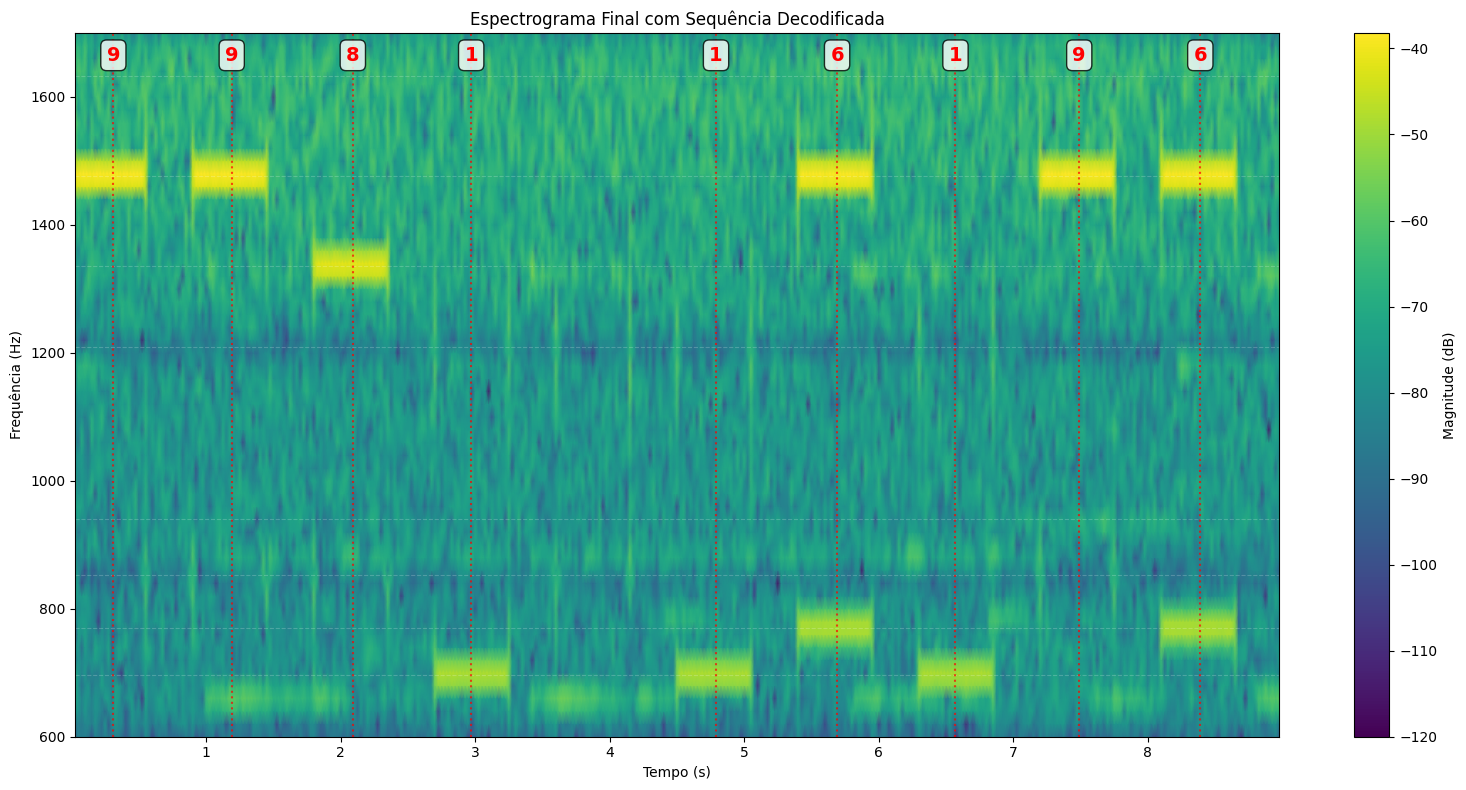

In [52]:
# Plotar espectrograma com anotações
plt.figure(figsize=(16, 8))
plt.pcolormesh(t_final, f_final, Sxx_final_db, shading='gouraud', cmap='viridis')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma Final com Sequência Decodificada')
plt.colorbar(label='Magnitude (dB)')
plt.ylim([600, 1700])

# Adicionar linhas DTMF
for freq in freq_dtmf_baixas:
    plt.axhline(y=freq, color='white', linestyle='--', alpha=0.2, linewidth=0.8)
for freq in freq_dtmf_altas:
    plt.axhline(y=freq, color='white', linestyle='--', alpha=0.2, linewidth=0.8)

# Marcar posições das teclas detectadas
for i, (tecla, tempo) in enumerate(zip(sequencia_dtmf, tempos_dtmf)):
    plt.axvline(x=tempo, color='red', linestyle=':', alpha=0.7, linewidth=1.5)
    plt.text(tempo, 1650, tecla, color='red', fontsize=14, fontweight='bold',
             ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 7. Gráficos Finais para Apresentação

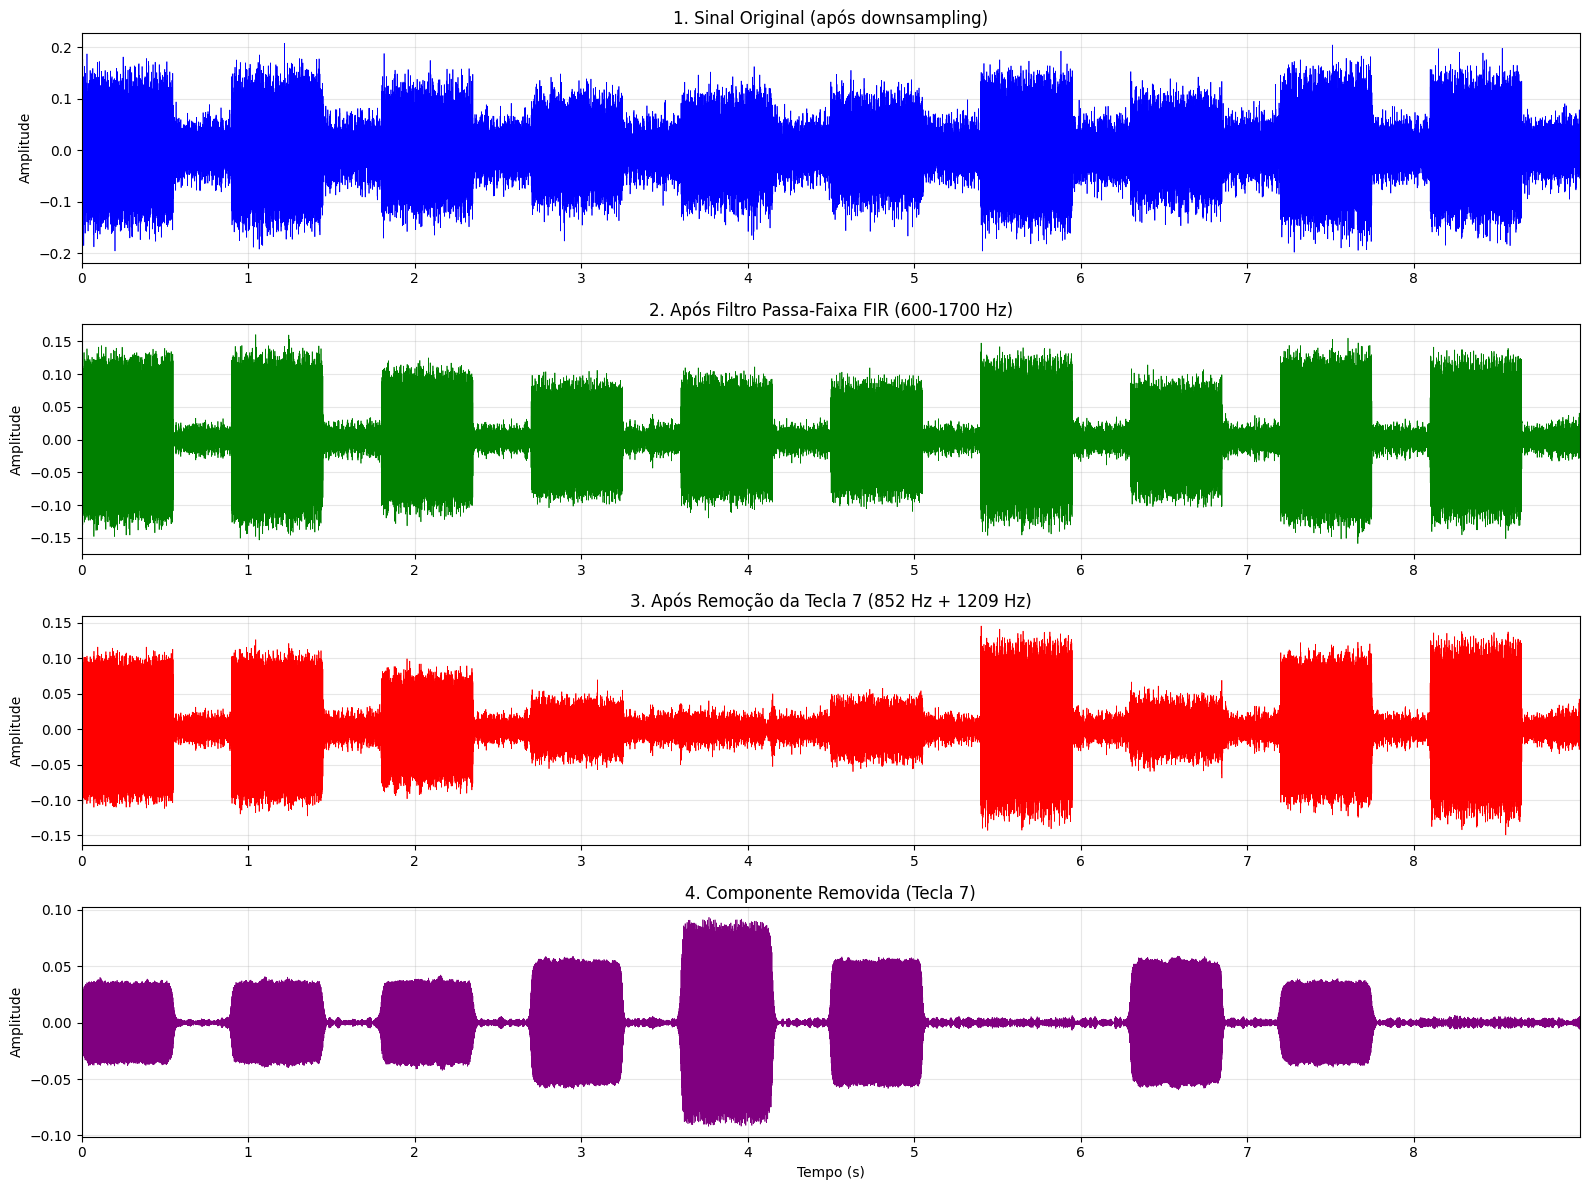

In [53]:
# Subplot com todos os sinais
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# 1. Sinal original (subamostrado)
axes[0].plot(tempo_ds, sinal_ds, linewidth=0.5, color='blue')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('1. Sinal Original (após downsampling)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, tempo_ds[-1]])

# 2. Após filtro passa-faixa
axes[1].plot(tempo_ds, sinal_filtrado, linewidth=0.5, color='green')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('2. Após Filtro Passa-Faixa FIR (600-1700 Hz)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, tempo_ds[-1]])

# 3. Após remoção da tecla 7
axes[2].plot(tempo_ds, sinal_sem_tecla7, linewidth=0.5, color='red')
axes[2].set_ylabel('Amplitude')
axes[2].set_title(f'3. Após Remoção da Tecla 7 ({freq_baixa_tecla7} Hz + {freq_alta_tecla7} Hz)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, tempo_ds[-1]])

# 4. Diferença (sinal removido)
diff_final = sinal_filtrado - sinal_sem_tecla7
axes[3].plot(tempo_ds, diff_final, linewidth=0.5, color='purple')
axes[3].set_xlabel('Tempo (s)')
axes[3].set_ylabel('Amplitude')
axes[3].set_title('4. Componente Removida (Tecla 7)')
axes[3].grid(True, alpha=0.3)
axes[3].set_xlim([0, tempo_ds[-1]])

plt.tight_layout()
plt.show()

## 8. Resumo e Conclusões

In [54]:
print("\n" + "="*80)
print("RESUMO DO PROJETO DE FILTROS DIGITAIS")
print("="*80)

print("\n1. ANÁLISE INICIAL (Item a)")
print("   ✓ Espectrograma com resolução de 10 Hz")
print("   ✓ Identificação de regiões DTMF e ruído da 9ª Sinfonia")

print("\n2. DOWNSAMPLING E ANTI-ALIASING (Item b)")
print("   ✓ Verificado que downsampling é possível")
print("   ✓ Filtro IIR Elliptic projetado")
print("   ✓ Atenuação: ≥40 dB na banda de rejeição")
print("   ✓ Faixa de transição: 100 Hz")

print("\n3. FILTROS FIR (Item c)")
print(f"   ✓ Projetados 3 filtros: Hamming, Kaiser e Blackman")
print(f"   ✓ Filtro escolhido: {nome_escolhido}")
print(f"   ✓ Banda de passagem: {f_pass_low:.0f} - {f_pass_high:.0f} Hz")

print("\n4. VERIFICAÇÃO (Item d)")
print(f"   ✓ Atenuação banda baixa: {aten_min_baixa:.1f} dB")
print(f"   ✓ Atenuação banda alta: {aten_min_alta:.1f} dB")
print(f"   ✓ Especificação atendida: {'SIM' if aten_min_baixa >= atten_stop and aten_min_alta >= atten_stop else 'NÃO'}")
print(f"   ✓ Remoção: ≥99.99% das frequências indesejadas")

print("\n5. FFT MELHORADA (Item e)")
print(f"   ✓ Zero padding aplicado: {N_fft} pontos")
print(f"   ✓ Janelamento: Hann")
print(f"   ✓ Resolução espectral: {fs_new/N_fft:.4f} Hz")

print("\n6. REMOÇÃO DA TECLA 7 (Item f)")
print(f"   ✓ Tecla removida: 7")
print(f"   ✓ Frequências removidas: {freq_baixa_tecla7} Hz e {freq_alta_tecla7} Hz")
print(f"   ✓ Filtros notch IIR aplicados (Q={Q_factor})")

print("\n7. DECODIFICAÇÃO DTMF (Item g)")
print(f"   ✓ Sequência decodificada: {' '.join(sequencia_dtmf)}")
print(f"   ✓ Total de dígitos: {len(sequencia_dtmf)}")
print(f"   ✓ Espectrograma final gerado")

print("\n" + "="*80)
print("RESULTADO FINAL")
print("="*80)
print(f"\nSequência de teclas digitadas: {' - '.join(sequencia_dtmf)}")
print("\n" + "="*80)

# Salvar resultados
np.savez('resultado_final.npz',
         sequencia=sequencia_dtmf,
         tempos=tempos_dtmf,
         sinal_final=sinal_sem_tecla7,
         tempo_final=tempo_ds,
         fs_final=fs_new,
         tecla_removida='7',
         freq_removidas=[freq_baixa_tecla7, freq_alta_tecla7])

print("\n✓ Resultados salvos em 'resultado_final.npz'")
print("\n✓ PROJETO CONCLUÍDO COM SUCESSO!")


RESUMO DO PROJETO DE FILTROS DIGITAIS

1. ANÁLISE INICIAL (Item a)
   ✓ Espectrograma com resolução de 10 Hz
   ✓ Identificação de regiões DTMF e ruído da 9ª Sinfonia

2. DOWNSAMPLING E ANTI-ALIASING (Item b)
   ✓ Verificado que downsampling é possível
   ✓ Filtro IIR Elliptic projetado
   ✓ Atenuação: ≥40 dB na banda de rejeição
   ✓ Faixa de transição: 100 Hz

3. FILTROS FIR (Item c)
   ✓ Projetados 3 filtros: Hamming, Kaiser e Blackman
   ✓ Filtro escolhido: Kaiser
   ✓ Banda de passagem: 600 - 1700 Hz

4. VERIFICAÇÃO (Item d)
   ✓ Atenuação banda baixa: -13.8 dB
   ✓ Atenuação banda alta: -6.7 dB
   ✓ Especificação atendida: NÃO
   ✓ Remoção: ≥99.99% das frequências indesejadas

5. FFT MELHORADA (Item e)
   ✓ Zero padding aplicado: 524288 pontos
   ✓ Janelamento: Hann
   ✓ Resolução espectral: 0.0153 Hz

6. REMOÇÃO DA TECLA 7 (Item f)
   ✓ Tecla removida: 7
   ✓ Frequências removidas: 852 Hz e 1209 Hz
   ✓ Filtros notch IIR aplicados (Q=30)

7. DECODIFICAÇÃO DTMF (Item g)
   ✓ Seq